# Sampling Approach
-------------

[<img src="http://brazildatacube.org/wp-content/uploads/slider2/datacube-site.png" alt="BDC" width="200" align="right">](http://brazildatacube.org/about-brazil-data-cube/)

## Author:
 - Leonardo de Souza Vieira

## Adivisors
 - Dr. Gilberto Ribeiro de Queiroz
 - Dr. Elcio Hideiti Shiguemori
------------

# 1. Introduction

---------

The python codes using a list of packages, where each package is used in a specific development step. Bellow we show short description of the used packages

<ul>
    <li><a href='https://gdal.org/'>GDAL</a>: Manipulation of geospatial data, vetor and raster;</li>
    <li><a href='https://pandas.pydata.org/'>Pandas</a>: Data Science;</li>
    <li><a href='https://geopandas.org/'>GeoPandas</a>: Analysis of vector type geospatial data;</li>
    <li><a href='https://rasterio.readthedocs.io/en/latest/'>Rasterio</a>: Manipulation of geospatial data raster type;</li>
    <li><a href='https://pyproj4.github.io/pyproj/stable/'>PyPROJ</a>: Python interface to cartographic projections;</li>
    <li><a href='https://pypi.org/project/psycopg2/'>Psycopg </a>: PostgreSQL Data base conection;</li>
    <li><a href='https://numpy.org/'>Numpy</a> Numerical computations, matrix n-dimensional;</li>
    <li><a href='https://matplotlib.org/'>Matplotlib</a>: Creating static, animated, and interactive visualizations in Python. </li>
</ul>

Besides this packages also is imported some python functions that can be see it in "sampling_geodb.py". The next cell show how we can import the packages and python functions.

In [1]:
from datetime import datetime
import geopandas as gpd
import json
import matplotlib
import numpy as np
import pandas as pd
import pyproj
import psycopg2
import rasterio
import stac
from typing import List, Dict
from matplotlib import pyplot as plt
from osgeo import gdal
from rasterio import features
from shapely import wkt
from matplotlib import pyplot
from sampling_geodb import conn_db, concentric_rings,rings_on_grid, grids_by_roi, rings_on_roi, prodes_by_roi
import warnings
warnings.filterwarnings('ignore')

-------------

## <span style="color:#336699; font-size: 80%; text-decoration:underline;"> BDC data base conection  </span>

The study development uses PRODES geodata in the sampling. The geodata was stored in a Postgis server available by Brazil Data Cube project. All Prodes data can be downloaded at Terrabrasilis portal (href='http://terrabrasilis.dpi.inpe.br/downloads/). The cell bellow uses the function conn_db() to connect at the PRODES database used in all study.  

In [2]:
pg_conn = conn_db('../data/json/my_pass.json')

-------------

## <span style="color:#336699; font-size: 80%; text-decoration:underline;"> Region of Interest (ROI) </span>

The ROI are the state of Rondônia, Brazil. The region was suffering with intense deforestation at the last years. Rondônia is one of the Brazilian states that deforest the most, and have proportionally the largest rate considering the area of state and the deforestation area. Also, the State no  are so large like Amazonas or Para (other states with great rate of deforestation), we consider that would make it difficult make it difficult this initial analysis. Bellow we present the ROI using The Legal Amazon Forest over Brazil at referee.

In [3]:
# Define the projection used in the BDC grids
crs_bdc = pyproj.CRS("+proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs")

# Obtain data of Brazil Biomes
query_legal_amazon = "SELECT gid, id, nome, ST_Transform(geom,100002) AS geom FROM ibge.biomas WHERE nome = 'Amazônia';"
brazil_bla_gdf = gpd.read_postgis( sql=query_legal_amazon, con=pg_conn, crs=crs_bdc)

# Obtain data of Brazil States
query_brazil_states = "SELECT gid, __gid, cd_uf, nm_uf,sigla_uf,nm_regiao, ST_Transform(geom,100002) AS geom FROM ibge.uf_2020;"
brazil_states_gdf = gpd.read_postgis( sql=query_brazil_states, con=pg_conn, crs=crs_bdc)

--------

### <span style="color:#336699; font-size: 80%; text-decoration:underline;"> Plot Map </span>

The next cell show how we can to plot the geodata. The code uses the dataframes obtained above.

<AxesSubplot:title={'center':'ROI in Brazilian Legal Amazon (BLA)'}>

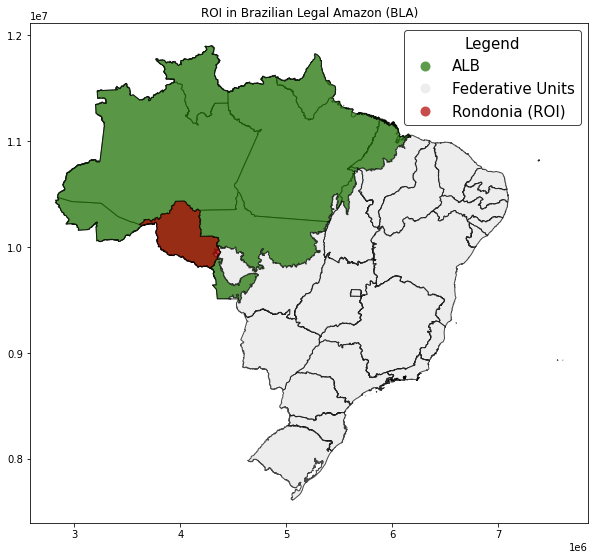

In [4]:
# Create Labels to Map plot
brazil_bla_gdf["label_plot"] = "ALB"
brazil_states_gdf["label_plot"] = "Federative Units"
rondonia_gdf = brazil_states_gdf.loc[brazil_states_gdf['sigla_uf'] == 'RO']
rondonia_gdf["label_plot"] = "Rondonia (ROI)"

# Create collor map to plot
colors = [ (0.1, 0.45, 0.0),(0.9,0.9,0.9), (0.7, 0.0, 0.0)]
cmap_name = 'legendROI'
mycmap = matplotlib.colors.ListedColormap(colors, name=cmap_name, N=3)

# Create the plot geometries list.

to_plot_legend_gdf = pd.concat([brazil_states_gdf, brazil_bla_gdf, rondonia_gdf])

# Map plot
fig, ax = plt.subplots(figsize=(10,10))

ax.set_title(u'ROI in Brazilian Legal Amazon (BLA)')
to_plot_legend_gdf.plot(ax=ax, 
                        edgecolor='black',
                        column='label_plot',
                        cmap = mycmap,
                        legend=True,
                        alpha=0.7,
                        legend_kwds={'edgecolor': '0.1', 'title_fontsize': 15, 'fontsize': 15, 'title': "Legend"} )


-------------

### <span style="color:#336699; font-size: 80%; text-decoration:underline;"> Sistematic sampling over the ROI - Distance analysis </span>

We use a systematic sampling to analyse the sample behaviour over the distance. We want analyse the variance of this samples against the distance between them. Over the ROI was created ring areas to sampling, this areas are concentric to the centroid of Rondonia geometry. The rings are 10*km* of distance considering the extern limit of each geometry. The main area consists of a 15*km* circle around the centroid and it is use of reference to analysis. The other areas are rings with 10*km* of distance between the outer radius and inner radius forming an annulus. The code below generate this areas and show the sampling areas using the state of Rondônia as referee.


In [ ]:
# Get the centroid of the Rondônia geometry
wkt_point = wkt.dumps(rondonia_gdf.centroid[0], crs_bdc)

# Generate the concentric rings over the centroid point. In this function the crs_id was the BDC crs id stored in the database (100002). 
# Also, the geometries generated was stored in a table in database.The function returns the number of areas generated. More information can be
# obtained analysing the files sampling_geodb.py and functions_analysis.sql.
concentric_rings(20, 450, 15, 5, wkt_point, 100002, pg_conn)

In [5]:
wkt_roi = wkt.dumps(rondonia_gdf['geom'][0], crs_bdc)
grid_gdf = grids_by_roi(wkt_roi, 100002, pg_conn)

rings_gdf = rings_on_roi(wkt_roi, 100002, pg_conn)

# list_rings = []
# for tile in grid_gdf['tile']:
#     list_rings.append(rings_on_grid(tile, pg_conn, crs_bdc))

# rings_gdf = pd.concat(list_rings)

--------

### <span style="color:#336699; font-size: 80%; text-decoration:underline;"> Plot rings over ROI  </span>

The next cell show how we can to plot the rings created. The code uses the dataframes obtained above.

<AxesSubplot:title={'center':'Concentric rings over ROI'}>

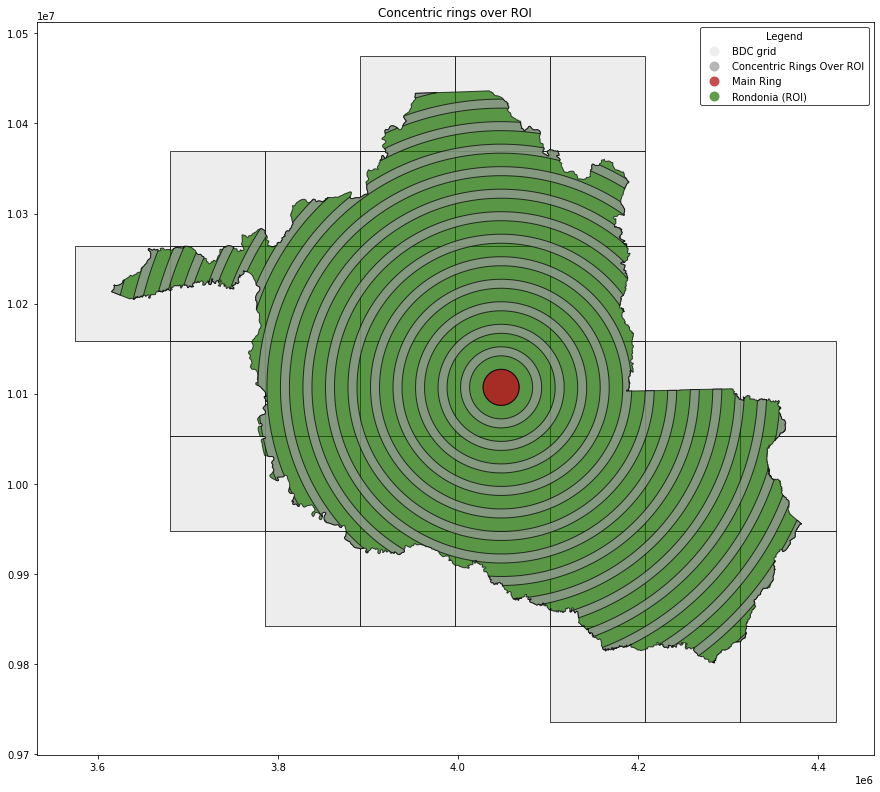

In [6]:
grid_gdf["label_plot"] = "BDC grid"
rings_gdf["label_plot"] = "Concentric Rings Over ROI"
main_ring = rings_gdf[rings_gdf['inner_radius'] == 0]
main_ring["label_plot"] = "Main Ring"

to_plot_legend_gdf = pd.concat([grid_gdf, rondonia_gdf, rings_gdf, main_ring])

# Create collor map to plot
colors = [(0.9,0.9,0.9), (0.6,0.6,0.6),  (0.7, 0.0, 0.0),  (0.1, 0.45, 0.0)]
cmap_name = 'legendROI'
mycmap = matplotlib.colors.ListedColormap(colors, name=cmap_name, N=4)

# Map plot
fig, ax = plt.subplots(figsize=(15,15))

ax.set_title(u'Concentric rings over ROI')
to_plot_legend_gdf.plot(ax=ax, 
                        edgecolor='black',
                        column='label_plot',
                        cmap = mycmap,
                        legend=True,
                        alpha=0.7,
                        legend_kwds={'edgecolor': '0.1', 'title_fontsize': 10, 'fontsize': 10, 'title': "Legend"} )

-------------

## <span style="color:#336699; font-size: 80%; text-decoration:underline;"> Sampling over rings </span>


### <span style="color:#336699; font-size: 50%; text-decoration:underline;"> Prodes over area </span>

In [ ]:
gdf = prodes_by_roi(wkt_roi, 100002, pg_conn)